In [1]:
import torch
import torchtext.vocab as vocab
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate
import argparse
import jsonlines
import ujson as json
import numpy as np
import nltk
import os
import shutil
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
UNKNOWN = '**UNK**'
PADDING = '**PAD**'
GO = '**GO**'  # it's called "GO" but actually serves as a null alignment

In [27]:
params = argparse.Namespace()
params.projection_dim = 200
params.batch_size = 32
params.max_len = 100
params.hidden_dim = params.projection_dim
params.train_file = "/home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_train.jsonl"
params.train_small_file = "/home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_train_small.jsonl"
params.dev_file = "/home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_dev_matched.jsonl"
params.dev_mistmatched_file = "/home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_dev_mismatched.jsonl"
params.lr = 0.0001
params.seed = 7
params.gru_encode = False
params.dropout = 0.2
params.nr_classes = 3
params.epochs = 300
params.patience = 20
params.resume = False
params.extra_debug = False
params.use_optimizations = False
params.use_intra_attention = True
torch.manual_seed(params.seed);

In [4]:
# Modified version of utils and ioutils classes from https://github.com/erickrf/multiffn-nli
class NLIDataset(Dataset):

    def __init__(self, sentences1, sentences2, sizes1, sizes2, labels):
        """
        :param sentences1: A 2D numpy array with sentences (the first in each
            pair) composed of token indices
        :param sentences2: Same as above for the second sentence in each pair
        :param sizes1: A 1D numpy array with the size of each sentence in the
            first group. Sentences should be filled with the PADDING token after
            that point
        :param sizes2: Same as above
        :param labels: 1D numpy array with labels as integers
        """
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.sizes1 = sizes1
        self.sizes2 = sizes2
        self.labels = labels
        self.num_items = len(sentences1)

    def shuffle_data(self):
        """
        Shuffle all data using the same random sequence.
        :return:
        """
        shuffle_arrays(self.sentences1, self.sentences2,
                       self.sizes1, self.sizes2, self.labels)

    def get_batch(self, from_, to):
        """
        Return an NLIDataset object with the subset of the data contained in
        the given interval. Note that the actual number of items may be less
        than (`to` - `from_`) if there are not enough of them.
        :param from_: which position to start from
        :param to: which position to end
        :return: an NLIDataset object
        """
        if from_ == 0 and to >= self.num_items:
            return self

        subset = NLIDataset(self.sentences1[from_:to],
                            self.sentences2[from_:to],
                            self.sizes1[from_:to],
                            self.sizes2[from_:to],
                            self.labels[from_:to])
        return subset
    
    def __len__(self):
        return self.num_items
    
    def __getitem__(self, idx):
        return self.sentences1[idx], self.sentences2[idx], self.labels[idx]
    

class BatchedNLIDataset(Dataset):

    def __init__(self, pairs, word_dict, sizes1, sizes2, label_dict):
        self.pairs = pairs
        self.label_dict = label_dict
        self.word_dict = word_dict
        self.max_len1 = sizes1
        self.max_len2 = sizes2

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pairs = self.pairs[idx]
        tokens1 = [pair[0] for pair in pairs]
        tokens2 = [pair[1] for pair in pairs]
        sentences1, sizes1 = utils._convert_pairs_to_indices(tokens1, self.word_dict,
                                                             self.max_len1)
        sentences2, sizes2 = utils._convert_pairs_to_indices(tokens2, self.word_dict,
                                                             self.max_len2)
        if self.label_dict is not None:
            labels = utils.convert_labels(pairs, self.label_dict)
        else:
            labels = None
        
        return sentences1, sentences2, labels

    
        

class Utils:
    def tokenize_english(self, text):
        return tokenizer.tokenize(text)


    def tokenize_corpus(self, pairs):
        tokenized_pairs = []
        for sent1, sent2, label in pairs:
            tokens1 = self.tokenize_english(sent1)
            tokens2 = self.tokenize_english(sent2)
            tokenized_pairs.append((tokens1, tokens2, label))

        return tokenized_pairs

    def count_corpus_tokens(self, pairs):
        """
        Examine all pairs ans extracts all tokens from both text and hypothesis.
        :param pairs: a list of tuples (sent1, sent2, relation) with tokenized
            sentences
        :return: a Counter of lowercase tokens
        """
        c = Counter()
        for sent1, sent2, _ in pairs:
            c.update(t.lower() for t in sent1)
            c.update(t.lower() for t in sent2)

        return c

    def shuffle_arrays(self, *arrays):
        rng_state = np.random.get_state()
        for array in arrays:
            np.random.shuffle(array)
            np.random.set_state(rng_state)

    def create_label_dict(self, pairs):
        """
        Return a dictionary mapping the labels found in `pairs` to numbers
        :param pairs: a list of tuples (_, _, label), with label as a string
        :return: a dict
        """
        labels = set(pair[2] for pair in pairs)
        mapping = zip(labels, range(len(labels)))
        params.nr_classes = len(labels)
        return dict(mapping)


    def convert_labels(self, pairs, label_map):
        """
        Return a numpy array representing the labels in `pairs`
        :param pairs: a list of tuples (_, _, label), with label as a string
        :param label_map: dictionary mapping label strings to numbers
        :return: a numpy array
        """
        return np.array([label_map[pair[2]] for pair in pairs], dtype=np.int32)


    def create_dataset(self, pairs, word_dict, label_dict=None,
                       max_len1=None, max_len2=None):
        """
        Generate and return a RTEDataset object for storing the data in numpy format.
        :param pairs: list of tokenized tuples (sent1, sent2, label)
        :param word_dict: a dictionary mapping words to indices
        :param label_dict: a dictionary mapping labels to numbers. If None,
            labels are ignored.
        :param max_len1: the maximum length that arrays for sentence 1
            should have (i.e., time steps for an LSTM). If None, it
            is computed from the data.
        :param max_len2: same as max_len1 for sentence 2
        :return: RTEDataset
        """
        tokens1 = [pair[0] for pair in pairs]
        tokens2 = [pair[1] for pair in pairs]
        sentences1, sizes1 = self._convert_pairs_to_indices(tokens1, word_dict,
                                                            max_len1)
        sentences2, sizes2 = self._convert_pairs_to_indices(tokens2, word_dict,
                                                            max_len2)
        if label_dict is not None:
            labels = self.convert_labels(pairs, label_dict)
        else:
            labels = None

        return NLIDataset(sentences1, sentences2, sizes1, sizes2, labels)
    
    
    def collate_batch(self, batch):
        if params.use_optimizations:
            premise = np.array([k for bat in batch for k in bat[0]], dtype=np.float)
            hypo = np.array([k for bat in batch for k in bat[1]], dtype=np.float)
            labels = np.array([k for bat in batch for k in bat[2]], dtype=np.float)
            return torch.from_numpy(premise), torch.from_numpy(hypo), torch.from_numpy(labels)
        else:
            return default_collate(batch)


    def _convert_pairs_to_indices(self, sentences, word_dict, max_len=None,
                                  use_null=True):
        sizes = np.array([len(sent) for sent in sentences])
        if use_null:
            sizes += 1
            if max_len is not None:
                max_len += 1

        if max_len is None:
            max_len = sizes.max()

        shape = (len(sentences), max_len)
        array = np.full(shape, word_dict[PADDING], dtype=np.int32)

        for i, sent in enumerate(sentences):
            words = []
            
            if len(sent) <= max_len - 1:
                words = sent
            else:
                idx = 0
                while len(words) < max_len - 1:
                    words.append(sent[idx])
                    idx += 1
                
            indices = [word_dict[token] for token in words]

            if use_null:
                indices = [word_dict[GO]] + indices

            array[i, :len(indices)] = indices

        return array, sizes


    def load_parameters(self, dirname):
        filename = os.path.join(dirname, 'model-params.json')
        with open(filename, 'rb') as f:
            data = json.load(f)

        return data


    def get_sentence_sizes(self, pairs):
        sizes1 = np.array([len(pair[0]) for pair in pairs])
        sizes2 = np.array([len(pair[1]) for pair in pairs])
        return (sizes1, sizes2)


    def get_max_sentence_sizes(self, pairs1, pairs2):
        train_sizes1, train_sizes2 = self.get_sentence_sizes(pairs1)
        valid_sizes1, valid_sizes2 = self.get_sentence_sizes(pairs2)
        train_max1 = max(train_sizes1)
        valid_max1 = max(valid_sizes1)
        max_size1 = max(train_max1, valid_max1)
        train_max2 = max(train_sizes2)
        valid_max2 = max(valid_sizes2)
        max_size2 = max(train_max2, valid_max2)

        return max_size1, max_size2


    def normalize_embeddings(self, embeddings):
        """
        Normalize the embeddings to have norm 1.
        :param embeddings: 2-d numpy array
        :return: normalized embeddings
        """
        # normalize embeddings
        norms = np.linalg.norm(embeddings.numpy(), axis=1).reshape((-1, 1))
        embeddings = torch.from_numpy(embeddings.numpy() / norms)
        return embeddings
    
    def save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        epoch = state['epoch']
        print("=> Saving model to %s" % filename)
        if epoch % 50 == 0 and epoch != 0:
            shutil.copyfile(filename, 'model_' + str(epoch) + '.pth.tar')
        if is_best:
            print("=> The model just saved has performed best on validation set" +
                     " till now")
            shutil.copyfile(filename, 'model_best.pth.tar')
        
        return filename


    def load_checkpoint(self, resume):
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            print("=> loaded checkpoint '{}' (epoch {})"
                     .format(resume, checkpoint['epoch']))
            return checkpoint
        else:
            print("=> no checkpoint found at '{}'".format(resume))
            return None
    
    def get_time_hhmmss(self, start = None):
        """
        Calculates time since `start` and formats as a string.
        """
        if start is None:
            return time.strftime("%Y/%m/%d %H:%M:%S")
        end = time.time()
        m, s = divmod(end - start, 60)
        h, m = divmod(m, 60)
        time_str = "%02d:%02d:%02d" % (h, m, s)
        return time_str  

utils = Utils()

In [5]:
class IO:
    def _generate_random_vector(self, size):
        """
        Generate a random vector from a uniform distribution between
        -0.1 and 0.1.
        """
        return np.random.uniform(-0.1, 0.1, size)

    def write_extra_embeddings(self, embeddings, dirname):
        """
        Write the extra embeddings (for unknown, padding and null)
        to a numpy file. They are assumed to be the first three in
        the embeddings model.
        """
        path = os.path.join(dirname, 'extra-embeddings.npy')
        torch.save(embeddings[:3], path)
        
    def load_embeddings(self, normalize=True, generate=True):
        glove = vocab.GloVe(name='6B', dim=params.projection_dim)
        wordlist, embeddings = glove.stoi, glove.vectors

        mapping = zip(wordlist, range(3, len(wordlist) + 3))

        # always map OOV words to 0
        wd = defaultdict(int, mapping)
        wd[UNKNOWN] = 0
        wd[PADDING] = 1
        wd[GO] = 2

        if generate:
            vector_size = embeddings.shape[1]
            extra = torch.FloatTensor([
                     self._generate_random_vector(vector_size),
                     self._generate_random_vector(vector_size),
                     self._generate_random_vector(vector_size)])
            self.write_extra_embeddings(extra, "/scratch/as10656/")

        else:
            path = os.path.join(load_extra_from, 'extra-embeddings.npy')
            extra = torch.load(path)

        embeddings = torch.cat((extra, embeddings), 0)


        print('Embeddings have shape {}'.format(embeddings.shape))
        if normalize:
            embeddings = utils.normalize_embeddings(embeddings)

        nn_embedding = nn.Embedding(embeddings.shape[0],
                                    embeddings.shape[1])

        nn_embedding.weight.data.copy_(embeddings)

        # Fix weights for training
        nn_embedding.weight.requires_grad = False


        return wd, nn_embedding

    def read_corpus(self, filename, lowercase, language='en'):
        print('Reading data from %s' % filename)
        # we are only interested in the actual sentences + gold label
        # the corpus files has a few more things
        useful_data = []
        # the Multinli corpus has one JSON object per line
        with open(filename, 'rb') as f:
            for line in f:
                line = line.decode('utf-8')
                if lowercase:
                    line = line.lower()
                data = json.loads(line)
                if data['gold_label'] == '-':
                    # ignore items without a gold label
                    continue
                    
                sentence1_parse = data['sentence1_parse']
                sentence2_parse = data['sentence2_parse']
                label = data['gold_label']

                tree1 = nltk.Tree.fromstring(sentence1_parse)
                tree2 = nltk.Tree.fromstring(sentence2_parse)
                tokens1 = tree1.leaves()
                tokens2 = tree2.leaves()
                t = (tokens1, tokens2, label)
                useful_data.append(t)

        return useful_data

    def read_corpus_batched(self, filename, lowercase, language='en'):
        print('Reading data from %s' % filename)
        # we are only interested in the actual sentences + gold label
        # the corpus files has a few more things
        useful_data = []
        done = dict()
        # the Multinli corpus has one JSON object per line
        with open(filename, 'rb') as f:
            for line in f:
                line = line.decode('utf-8')
                if lowercase:
                    line = line.lower()
                data = json.loads(line)
                if data['gold_label'] == '-':
                    # ignore items without a gold label
                    continue
                prompt_id = data['promptid']
                
                if prompt_id not in done:
                    done[prompt_id] = len(useful_data)
                    useful_data.append([])
                
                sentence1_parse = data['sentence1_parse']
                sentence2_parse = data['sentence2_parse']
                label = data['gold_label']

                tree1 = nltk.Tree.fromstring(sentence1_parse)
                tree2 = nltk.Tree.fromstring(sentence2_parse)
                tokens1 = tree1.leaves()
                tokens2 = tree2.leaves()
                t = (tokens1, tokens2, label)
                useful_data[done[prompt_id]].append(t)

        return useful_data
    
io = IO()

In [20]:
class EarlyStopping(object):
    """
    Provides early stopping functionality. Keeps track of model accuracy, 
    and if it doesn't improve over time restores last best performing 
    parameters.
    """
    
    def __init__(self, model, optimizer, patience = 100, minimize = True):
        """
        Initialises a `EarlyStopping` isntance.

        Parameters
        ----------
        saver     : 
                    TensorFlow Saver object to be used for saving and restoring model.
        session   : 
                    TensorFlow Session object containing graph where model is restored.
        patience  : 
                    Early stopping patience. This is the number of epochs we wait for 
                    accuracy to start improving again before stopping and restoring 
                    previous best performing parameters.
                  
        Returns
        -------
        New instance.
        """
        self.minimize = minimize
        self.patience = patience
        self.model = model
        self.optimizer = optimizer
        self.best_monitored_value = 0. if minimize else np.inf
        self.best_monitored_acc = np.inf if minimize else 0.
        self.best_monitored_epoch = 0

        self.restore_path = None

    def __call__(self, value, acc, epoch, rest):
        """
        Checks if we need to stop and restores the last well performing values if we do.

        Parameters
        ----------
        value     : 
                    Last epoch monitored value.
        acc       :
                    Current accuracy
        epoch     : 
                    Last epoch number.
                  
        Returns
        -------
        `True` if we waited enough and it's time to stop and we restored the 
        best performing weights, or `False` otherwise.
        """
        if (self.minimize and acc < self.best_monitored_acc) or (not self.minimize and acc > self.best_monitored_acc):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.best_monitored_acc = acc
            state = {
                'epoch': epoch + 1,
                'state_dict': self.model.state_dict(),
                'best': value,
                'best_acc': acc,
                'optimizer': self.optimizer.state_dict(),
            }            
            
            rest.update(state)
            self.restore_path = utils.save_checkpoint(rest, True, "/scratch/as10656/nli_models/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                checkpoint = utils.load_checkpoint(self.restore_path)
                self.best_monitored_value = checkpoint['best']
                self.best_monitored_acc = checkpoint['best_acc']
                self.best_monitored_epoch = checkpoint['epoch']
                self.model.load_state_dict(checkpoint['state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer'])
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False
    
    def init_from_checkpoint(self, checkpoint):
        self.best_monitored_value = checkpoint['best']
        self.best_monitored_acc = checkpoint['best_acc']
        self.best_monitored_epoch = 0
    
    def print_info(self):
        print("Best loss: {0}, Best Accuracy: {1}, at epoch {2}"
              .format(self.best_monitored_value,
                      self.best_monitored_acc,
                      self.best_monitored_epoch))

In [41]:
def plot_curve(axis, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots a pair of validation and training curves on a single plot.
    """
    train_values = params[train_column]
    valid_values = params[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return epochs

# Plots history of learning curves for a specific model.
def plot_learning_curves(params):
    """
    Plots learning curves (loss and accuracy on both training and validation sets) for a model identified by a parameters struct.
    """
    curves_figure = plt.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = plot_curve(axis, params, train_column = "train_acc", valid_column = "val_acc")

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.ylim(45., 115.)
    plt.xlim(0, epochs_plotted)

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = plot_curve(axis, params, train_column = "train_loss", valid_column = "val_loss")

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.ylim(1, 50)
    plt.xlim(0, epochs_plotted)
#     plt.yscale("log")

In [8]:
wd, embeddings = io.load_embeddings()

Embeddings have shape torch.Size([400003, 200])


In [28]:
dev_pairs = io.read_corpus(params.dev_file, True)
label_dict = utils.create_label_dict(dev_pairs)
dev_data = utils.create_dataset(dev_pairs, wd, label_dict, max_len1=params.max_len, max_len2=params.max_len)

if params.use_optimizations:
    train_pairs = io.read_corpus_batched(params.train_file, True)
#     train_pairs = [pair for pairs in train_pairs for pair in pairs]
    train_data = BatchedNLIDataset(train_pairs, wd, params.max_len, params.max_len, label_dict)
else:
    train_pairs = io.read_corpus(params.train_file, True)
    train_data = utils.create_dataset(train_pairs, wd, label_dict, max_len1=params.max_len, max_len2=params.max_len)


del train_pairs
del dev_pairs

Reading data from /home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_dev_matched.jsonl
Reading data from /home/as10656/nli-batch-optimizations/multinli_1.0/multinli_1.0_train.jsonl


In [10]:
# Taken from allennlp
class TimeDistributed(torch.nn.Module):
    """
    Given an input shaped like ``(batch_size, time_steps, [rest])``
    and a ``Module`` that takes inputs like ``(batch_size, [rest])``,
    ``TimeDistributed`` reshapes the input to be
    ``(batch_size * time_steps, [rest])``, applies the contained ``Module``,
    then reshapes it back.
    Note that while the above gives shapes with ``batch_size`` first,
    this ``Module`` also works if ``batch_size`` is second -
    we always just combine the first two dimensions, then split them.
    """
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self._module = module

    def forward(self, *inputs):  # pylint: disable=arguments-differ
        reshaped_inputs = []
        for input_tensor in inputs:
            input_size = input_tensor.size()
            if len(input_size) <= 2:
                raise RuntimeError("No dimension to distribute: " +
                                   str(input_size))

            # Squash batch_size and time_steps into a single axis;
            # result has shape (batch_size * time_steps, input_size).
            squashed_shape = [-1] + [x for x in input_size[2:]]
            reshaped_inputs.append(
                input_tensor.contiguous().view(*squashed_shape))

        reshaped_outputs = self._module(*reshaped_inputs)

        # Now get the output back into the right shape.
        # (batch_size, time_steps, [hidden_size])
        new_shape = [input_size[0], input_size[1]] + \
                    [x for x in reshaped_outputs.size()[1:]]
        outputs = reshaped_outputs.contiguous().view(*new_shape)

        return outputs


In [11]:
def init_weights(model):
    # As mentioned in paper
    mean = 0
    stddev = 0.01
    for module in model.modules():
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean, stddev)


def get_embedded_mask(embedded):
    return (embedded != 1).float()

In [12]:
# from allennlp.modules import MatrixAttention, SimilarityFunction
# from allennlp.nn.util import get_text_field_mask, last_dim_softmax, weighted_sum

class DecomposableAttention(nn.Module):
    def __init__(self, settings, embeddings):
        super(DecomposableAttention, self).__init__()

        if isinstance(settings, argparse.Namespace):
            settings = vars(settings)
            
        self.embedding = embeddings
        self.settings = settings
        self.max_length = settings['max_len']
        self.hidden_dim = settings['hidden_dim']
        self.nr_classes = settings['nr_classes']
        
        if settings['hidden_dim'] != settings['projection_dim']:
            self.projection = nn.Linear(self.hidden_dim, settings['prjection_dim'])
        else:
            self.projection = lambda x: x
            
        settings['hidden_dim'] = settings['projection_dim']
        self.hidden_dim = settings['hidden_dim']

        if settings['gru_encode']:
            self.encoder = BiRNNEncoder(self.max_length, self.hidden_dim,
                                        dropout=settings['dropout'])
        if settings['use_intra_attention']:
            self.intra_sentence_attender = Attention(self.max_length,
                                                     self.hidden_dim,
                                                     dropout=settings['dropout'])

    #         similarity_function = SimilarityFunction.from_params({'type': 'dot_product'})
    #         self.matrix_attention = MatrixAttention(similarity_function)

            self.intra_align = SoftAlignment(self.max_length, self.hidden_dim)
            self.intra_align_project = nn.Linear(self.hidden_dim * 2,
                                                 self.hidden_dim)

        self.attender = Attention(self.max_length, self.hidden_dim,
                                  dropout=settings['dropout'])

        self.align = SoftAlignment(self.max_length, self.hidden_dim)

        self.compare = Comparison(self.max_length, self.hidden_dim,
                                  dropout=settings['dropout'])
        self.aggregate = Aggregate(self.hidden_dim, self.nr_classes,
                                   dropout=settings['dropout'])

        init_weights(self)

    def forward(self, premise, hypo):
        premise_mask = get_embedded_mask(premise)
        hypo_mask = get_embedded_mask(hypo)
        
        premise = self.embedding(premise)
        hypo = self.embedding(hypo)

        premise = self.projection(premise)
        hypo = self.projection(hypo)


        if self.settings['gru_encode']:
            premise = self.encoder(premise)
            hypo = self.encoder(hypo)

        if self.settings['use_intra_attention']:
            # Intra Sentence Attention
            premise = self.intra_attention(premise, premise_mask)
            hypo = self.intra_attention(hypo, hypo_mask)

            premise = self.intra_align_project(premise)
            hypo = self.intra_align_project(hypo)

        projected_premise = self.attender(premise)
        projected_hypo = self.attender(hypo)

        att_ji = projected_hypo.bmm(projected_premise.permute(0, 2, 1))

        # Shape: batch_length * max_length * max_length
        att_ij = att_ji.permute(0, 2, 1)

        aligned_hypo = self.align(hypo, hypo_mask, att_ij)
        aligned_premise = self.align(premise, premise_mask, att_ij, transpose=True)
        
        
#         similarity_matrix = self._matrix_attention(projected_premise, projected_hypo)

#         # Shape: (batch_size, premise_length, hypothesis_length)
#         p2h_attention = last_dim_softmax(similarity_matrix, hypo_mask)
#         # Shape: (batch_size, premise_length, embedding_dim)
#         aligned_hypothesis = weighted_sum(embedded_hypo, p2h_attention)

#         # Shape: (batch_size, hypothesis_length, premise_length)
#         h2p_attention = last_dim_softmax(similarity_matrix.transpose(1, 2).contiguous(), premise_mask)
#         # Shape: (batch_size, hypothesis_length, embedding_dim)
#         aligned_premise = weighted_sum(premise, h2p_attention)

        premise_compare_input = torch.cat([premise, aligned_hypo], dim=-1)
        hypo_compare_input = torch.cat([hypo, aligned_premise], dim=-1)

        compared_premise = self.compare(premise_compare_input)
        compared_premise = compared_premise * premise_mask.unsqueeze(-1)
        # Shape: (batch_size, compare_dim)
        compared_premise = compared_premise.sum(dim=1)

        compared_hypo = self.compare(hypo_compare_input)
        compared_hypo = compared_hypo * hypo_mask.unsqueeze(-1)
        # Shape: (batch_size, compare_dim)
        compared_hypo = compared_hypo.sum(dim=1)

        aggregate_input = torch.cat([compared_premise, compared_hypo], dim=-1)
        scores = self.aggregate(aggregate_input)

        return scores

    def intra_attention(self, sentence, sentence_mask):
        projected_sentence = self.intra_sentence_attender(sentence)
        intra_att_ji = projected_sentence.bmm(projected_sentence.permute(0, 2,
                                                                         1))
        intra_att_ij = intra_att_ji.permute(0, 2, 1)
        aligned_sentence = self.intra_align(sentence, sentence_mask, intra_att_ij)
        sentence = torch.cat([sentence, aligned_sentence], dim=-1)

        return sentence


In [13]:
class BiRNNEncoder(nn.Module):
    def __init__(self, max_length, nr_hidden, dropout=0.0):
        super(BiRNNEncoder, self).__init__()

        self.nr_hidden = nr_hidden

        self.fully_connected = nn.Sequential(
            nn.Linear(nr_hidden * 2, nr_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(nr_hidden, nr_hidden, max_length,
                            dropout=dropout,
                            bidirectional=True,
                            batch_first=True)
        self.fully_connected = TimeDistributed(self.fully_connected)
        self.dropout = nn.Dropout(p=dropout)

        init_weights(self)

    def forward(self, input):
        output, _ = self.lstm(input)
        return self.dropout(self.fully_connected(output))



In [14]:
class Attention(nn.Module):
    def __init__(self, max_length, nr_hidden, dropout=0.0):
        super(Attention, self).__init__()

        self.model = TimeDistributed(nn.Sequential(
            nn.Linear(nr_hidden, nr_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(nr_hidden, nr_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        ))

        init_weights(self.model)

    def forward(self, sentence):
        return self.model(sentence)



In [15]:
class SoftAlignment(nn.Module):
    def __init__(self, max_length, nr_hidden):
        super(SoftAlignment, self).__init__()

        self.max_length = max_length
        self.nr_hidden = nr_hidden

    def forward(self, sentence, mask, attention_matrix, transpose=False):
        if transpose:
            attention_matrix = attention_matrix.permute(0, 2, 1)

        exponents = torch.exp(attention_matrix -
                              torch.max(attention_matrix,
                                        dim=-1,
                                        keepdim=True)[0])
        
        exponents = exponents

        summation = torch.sum(exponents, dim=-1, keepdim=True)

        attention_weights = exponents / summation
        
        attention_weights = attention_weights * mask.unsqueeze(-1)
        
        attention_weights = attention_weights / (attention_weights.sum(-1, keepdim=True) + 1e-13) 

        return attention_weights.bmm(sentence)


In [16]:
class Comparison(nn.Module):
    def __init__(self, max_length, nr_hidden, dropout=0):
        super(Comparison, self).__init__()

        self.max_length = max_length
        self.nr_hidden = nr_hidden
        self.model = TimeDistributed(nn.Sequential(
            nn.Linear(nr_hidden * 2, nr_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(nr_hidden, nr_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        ))
        init_weights(self.model)

    def forward(self, concatenated_aligned_sentence):
        return self.model(concatenated_aligned_sentence)


In [17]:
class Aggregate(nn.Module):
    def __init__(self, nr_hidden, nr_out, dropout=0.0):
        super(Aggregate, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(nr_hidden * 2, nr_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(nr_hidden, nr_out)
        )

        init_weights(self.model)

    def forward(self, input):
        return self.model(input)

In [42]:
class Trainer:
    def __init__(self, params, train_data, dev_data, embedding):
        self.params = params
        self.train_data = train_data
        self.dev_data = dev_data
        self.epochs = params.epochs
        print("Creating dataloaders")
        self.cuda_available = torch.cuda.is_available()
        
        self.train_loader = DataLoader(dataset=train_data,
                                       shuffle=True,
                                       batch_size=params.batch_size,
                                       pin_memory=self.cuda_available,
                                       collate_fn=utils.collate_batch)
        self.dev_loader = DataLoader(dataset=dev_data,
                                     shuffle=False,
                                     batch_size=params.batch_size,
                                     pin_memory=self.cuda_available)
        
        self.string_fixer = "=========="
        self.embedding = embedding

        
    def train(self):
        criterion = nn.CrossEntropyLoss()
        model = DecomposableAttention(self.params, embeddings)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                      model.parameters()),
                               lr=params.lr)

        start_epoch = 0
        best_prec = 0
        self.start_time = time.time()
        self.histories = {
            "train_loss": np.empty(0, dtype=np.float32),
            "train_acc": np.empty(0, dtype=np.float32),
            "val_loss": np.empty(0, dtype=np.float32),
            "val_acc": np.empty(0, dtype=np.float32)
        }
        
        
        self.early_stopping = EarlyStopping(model, optimizer, patience=self.params.patience, minimize=False)
        if self.params.resume:
            checkpoint = utils.load_checkpoint(self.params.resume)
            if checkpoint is not None:
                model.load_state_dict(checkpoint['state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer'])
                self.histories.update(checkpoint)
                self.early_stopping.init_from_checkpoint(checkpoint)
                print("Loaded model, Best Loss: %.8f, Best Acc: %.2f" % (checkpoint['best'], checkpoint['best_acc']))

        is_best = False

        if self.cuda_available:
            model = model.cuda()

        
        model.train()
        print("Starting training")
        self.print_info()
        for epoch in range(start_epoch, params.epochs):
            for i, (premise, hypo, labels) in enumerate(self.train_loader):
                premise_batch = Variable(premise.long())
                hypo_batch = Variable(hypo.long())
                labels_batch = Variable(labels)
                if self.cuda_available:
                    premise_batch = premise_batch.cuda()
                    hypo_batch = hypo_batch.cuda()
                    labels_batch = labels_batch.cuda(async=True)

                optimizer.zero_grad()
                output = model(premise_batch, hypo_batch)
                loss = criterion(output, labels_batch.long())
                loss.backward()
                optimizer.step()
                if self.params.extra_debug and (i + 1) % (self.params.batch_size * 4) == 0:
                    print(('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4},')
                             .format(epoch + 1,
                                     self.params.epochs,
                                     i + 1,
                                     len(self.train_loader),
                                     loss.data[0]))
            train_acc, train_loss = self.validate_model(self.train_loader, model)
            dev_acc, dev_loss = self.validate_model(self.dev_loader, model)
            
            self.histories['train_loss'] = np.append(self.histories['train_loss'], [train_loss])
            self.histories['val_loss'] = np.append(self.histories['val_loss'], [dev_loss])
            self.histories['val_acc'] = np.append(self.histories['val_acc'], [dev_acc])
            self.histories['train_acc'] = np.append(self.histories['train_acc'], [train_acc])
            
            if not self.early_stopping(dev_loss, dev_acc, epoch, self.histories):
                self.print_train_info(epoch, train_acc, train_loss, dev_acc, dev_loss)
            else:
                print("Early stopping activated")
                print("Restoring earlier state and stopping")
                self.early_stopping.print_info()
                plot_learning_curves(self.histories)
                plt.show()
                break
            

            
    def validate_model(self, loader, model):
        model.eval()
        correct = 0
        total = 0
        total_loss = 0

        for premise, hypo, labels in loader:
            premise_batch = Variable(premise.long(), volatile=True)
            hypo_batch = Variable(hypo.long(), volatile=True)
            labels_batch = Variable(labels.long())

            if self.cuda_available:
                premise_batch = premise_batch.cuda()
                hypo_batch = hypo_batch.cuda()
                labels_batch = labels_batch.cuda()

            output = model(premise_batch, hypo_batch)
            loss = nn.functional.cross_entropy(output, labels_batch.long(), size_average=False)
            total_loss += len(premise_batch) * loss.data
            total += len(labels_batch)
            
            if not self.cuda_available:
                correct += (labels_batch == output.max(1)[1]).data.cpu().numpy().sum()
            else:
                correct += (labels_batch == output.max(1)[1]).data.sum()
                
        model.train()

        average_loss = total_loss[0] / total
        return correct / total * 100, average_loss

    def print_info(self):
        print(self.string_fixer + " Data " + self.string_fixer)
        print("Training set: %d examples" % (len(self.train_data)))
        print("Validation set: %d examples" % (len(self.dev_data)))
        print("Timestamp: %s" % utils.get_time_hhmmss())
        
        print(self.string_fixer + " Params " + self.string_fixer)
    
        print("Learning Rate: %f" % self.params.lr)
        print("Dropout (p): %f" % self.params.dropout)
        print("Batch Size: %d" % self.params.batch_size)
        print("Epochs: %d" % self.params.epochs)
        print("Patience: %d" % self.params.patience)
        print("Resume: %s" % self.params.resume)
        print("GRU Encode: %s" % str(self.params.gru_encode))
        print("Batch Optimizations: %s" % str(self.params.use_optimizations))
        print("Intra Attention: %s" % str(self.params.use_intra_attention))
        
    def print_train_info(self, epoch, train_acc, train_loss, dev_acc, dev_loss):
        print((self.string_fixer + " Epoch: {0}/{1} " + self.string_fixer)
              .format(epoch + 1, self.params.epochs))
        print("Train Loss: %.8f, Train Acc: %.2f" % (train_loss, train_acc))
        print("Validation Loss: %.8f, Validation Acc: %.2f" % (dev_loss, dev_acc))
        self.early_stopping.print_info()
        print("Elapsed Time: %s" % (utils.get_time_hhmmss(self.start_time)))
        print("Current timestamp: %s" % (utils.get_time_hhmmss()))

Creating dataloaders
=> loading checkpoint '/scratch/as10656/nli-intra.model'
=> loaded checkpoint '/scratch/as10656/nli-intra.model' (epoch 82)
Loaded model, Best Loss: 21.71986755, Best Acc: 71.14
Starting training
========== Data ==========
Training set: 392702 examples
Validation set: 9815 examples
Timestamp: 2017/12/02 01:34:38
========== Params ==========
Learning Rate: 0.000100
Dropout (p): 0.200000
Batch Size: 10
Epochs: 300
Patience: 30
Resume: /scratch/as10656/nli-intra.model
GRU Encode: False
Batch Optimizations: False
Intra Attention: True
Early stopping activated
Restoring earlier state and stopping
Best loss: 21.719867549668873, Best Accuracy: 71.13601630157922, at epoch 0


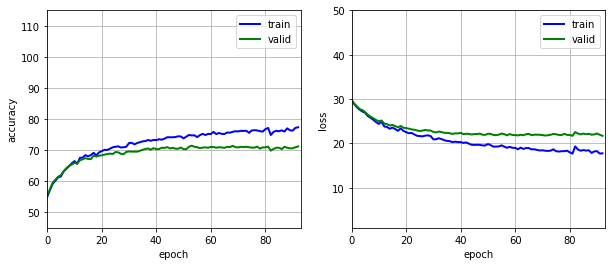

In [44]:
# params.resume = '/home/as10656/nli-batch-optimizations/parikh-et-al/model_best.pth.tar'
params.resume = '/scratch/as10656/nli-intra.model'
# params.resume = False
params.use_intra_attention = True
params.gru_encode = False
params.batch_size = 10
params.patience = 30
trainer = Trainer(params, train_data, dev_data, embeddings)
trainer.train()

In [ ]:
%%bash
nvidia-smi